# Dynamic Flux Balance Analysis (dFBA)

In [1]:
# !pip install cobra

In [2]:
import cobra
import matplotlib.pyplot as plt
from cobra.io import load_model

ecoli = load_model("textbook")
ecoli.reactions.EX_o2_e.lower_bound = -2
ecoli.reactions.ATPM.lower_bound = 1
ecoli.reactions.ATPM.upper_bound = 1

In [3]:
ecoli

Name,e_coli_core
Memory address,292397eb0
Number of metabolites,72
Number of reactions,95
Number of genes,137
Number of groups,0
Objective expression,1.0*Biomass_Ecoli_core - 1.0*Biomass_Ecoli_core_reverse_2cdba
Compartments,"cytosol, extracellular"


In [4]:
ecoli.optimize()

,fluxes,reduced_costs
ACALD,-5.028887,2.898276e-18
ACALDt,0.000000,-2.686655e-18
ACKr,-9.415924,-0.000000e+00
ACONTa,0.394348,-9.575910e-17
ACONTb,0.394348,2.164046e-16
...,...,...
TALA,-0.065390,-0.000000e+00
THD2,6.267054,9.974660e-17
TKT1,-0.065390,-0.000000e+00
TKT2,-0.197338,-3.966462e-18


## michaelis-menten kinetics

$
v = \frac{v_{max} \cdot [S]}{K_m + [S]}
$

## define functions

In [5]:
# define the function
def dfba_timestep(
    model, 
    initial_conditions, 
    kinetic_params, 
    substrate_to_reaction_map,
    biomass_name_map,
    dt,
):
    updated_state = initial_conditions.copy()

    for substrate_id, reaction_id in substrate_to_reaction_map.items():
        Km, Vmax = kinetic_params[substrate_id]
        substrate_concentration = initial_conditions[substrate_id]
        
        # calculate michaelis-menten flux
        flux = Vmax * substrate_concentration / (Km + substrate_concentration)

        # use the flux to constrain fba
        model.reactions.get_by_id(reaction_id).lower_bound = -flux

    # solve fba under these constraints
    solution = model.optimize()

    # gather the results
    ## update biomass
    biomass_growth_rate = solution.fluxes[biomass_name_map[1]]
    current_biomass = updated_state[biomass_name_map[0]]
    updated_state[biomass_name_map[0]] += biomass_growth_rate * current_biomass * dt

    ## update substrates
    for substrate_id, reaction_id in substrate_to_reaction_map.items():
        flux = solution.fluxes[reaction_id]
        current_substrate_conc = updated_state[substrate_id]
        updated_state[substrate_id] += flux * current_biomass * dt

    return updated_state

# perform a dfba simulation
def perform_dfba(
        model, 
        initial_conditions, 
        kinetic_params, 
        substrate_to_reaction_map,
        biomass_name_map,
        dt,
        total_steps,
    ):
    # placeholder for results
    results = {key: [value] for key, value in initial_conditions.items()}
    current_state = initial_conditions.copy()

    for t in range(0, total_steps):
        # call dfba for this timestep
        current_state = dfba_timestep(
            model, 
            current_state, 
            kinetic_params, 
            substrate_to_reaction_map,
            biomass_name_map,
            dt,
        )

        # record results
        for key, value in current_state.items():
            results[key].append(value)
        
    return results

def plot_dfba_results(total_steps, dfba_results):
    time_points = list(range(0, total_steps+1))
    plt.figure()
    for key, value in dfba_results.items():
        plt.plot(time_points, value, label=key)

    plt.xlabel('time step')
    plt.ylabel('concentration')
    plt.legend()
    plt.show()

In [6]:
# example
conditions1 = {
    'biomass': 0.1,  # initial biomass concentration
    'glucose': 20.0, # initial glucose concentrations
    'acetate': 0.0,  # initial acetate concentrations
}
kinetics1 = {
    'glucose': (0.5, 2),  # km and vmax for glucose
    'acetate': (0.5, 2),  # km and vmax for acetate
}
rxn_name_map = {
    'glucose': 'EX_glc__D_e',
    'acetate': 'EX_ac_e'
}
biomass_name_map = ('biomass', 'Biomass_Ecoli_core')

# define simulation timescale
time_interval = 0.1  # how long is a single timestep?
total_steps = 500  # how many steps of dfba do we want to run?

# call the dfba function and get results
dfba_results = perform_dfba(
    model=ecoli, 
    initial_conditions=conditions1, 
    kinetic_params=kinetics1,
    substrate_to_reaction_map=rxn_name_map,
    biomass_name_map=biomass_name_map,
    dt=time_interval,
    total_steps=total_steps,
)

/Users/eranagmon/code/bigraph-schema/venv/lib/python3.9/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


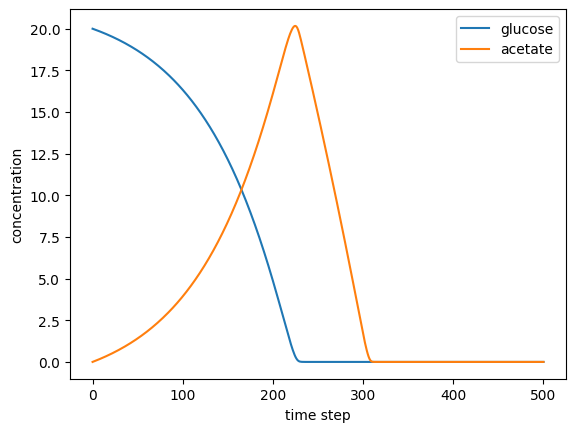

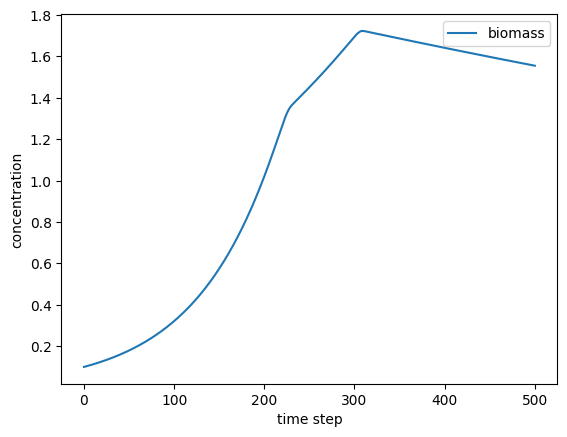

In [7]:
nutrient_results = {key: value for key, value in dfba_results.items() if key != 'biomass'}
biomass_results = {key: value for key, value in dfba_results.items() if key == 'biomass'}
plot_dfba_results(total_steps, nutrient_results)
plot_dfba_results(total_steps, biomass_results)

## multi-species dFBA

In [14]:
species1_model = ecoli.copy()

species2_model = ecoli.copy()

In [27]:
def update_shared_environment(current_state, species_results):
    # TODO -- hand each species' updates and update the current state accordingly
    return current_state

def perform_multi_species_dfba(initial_conditions, species_info, dt, total_time):
    current_state = initial_conditions.copy()
    results = {key: [value] for key, value in current_state.items()}

    # iterate through the simulation
    t = 0
    while t <= total_time:
        all_species_results = []
        for species in species_info:  # call a single dfba_timestep for this species
            species_result = dfba_timestep(
                model=species['model'], 
                initial_conditions=current_state, 
                kinetic_params=species['kinetic_params'], 
                substrate_to_reaction_map=species['substrate_to_reaction_map'],
                biomass_name_map=species['biomass_name_map'],
                dt=dt)

            # save this species' result
            all_species_results.append(species_result)

        # update the shared environment after retrieving all species updates
        current_state = update_shared_environment(current_state, all_species_results)
        
        # update time
        t += dt

        # collect results for this timestep
        for key, value in current_state.items():
            if key in results:
                results[key].append(value)
            else:
                results[key] = [value]
    
    return results

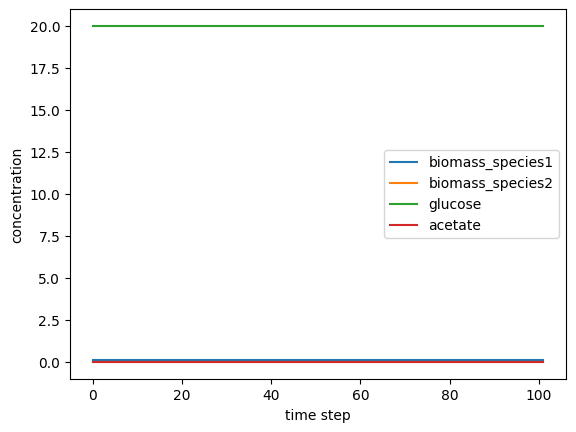

In [34]:
# example
initial_conditions = {
    'biomass_species1': 0.1,  # initial biomass concentration
    'biomass_species2': 0.01,  # initial biomass concentration
    'glucose': 20.0,          # initial glucose concentrations
    'acetate': 0.0}

# species 1 parameters
kinetic_params1 = {
    'glucose': (0.5, 2),  # km and vmax for glucose
    'acetate': (0.5, 2)}
rxn_name_map1 = {
    'glucose': 'EX_glc__D_e',
    'acetate': 'EX_ac_e'}
biomass_name_map1 = ('biomass_species1', 'Biomass_Ecoli_core')

# species 2 parameters
kinetic_params2 = {
    'glucose': (0.1, 1),  # km and vmax for glucose
    'acetate': (0.1, 1)}
rxn_name_map2 = {
    'glucose': 'EX_glc__D_e',
    'acetate': 'EX_ac_e'}
biomass_name_map2 = ('biomass_species2', 'Biomass_Ecoli_core')

# make a species_info example
species_info = [
    {
        'model': species1_model,                   # species 1
        'kinetic_params': kinetic_params1,
        'substrate_to_reaction_map': rxn_name_map1,
        'biomass_name_map': biomass_name_map1,
    },
    {
        'model': species2_model,                   # species 2 
        'kinetic_params': kinetic_params2,
        'substrate_to_reaction_map': rxn_name_map2,
        'biomass_name_map': biomass_name_map2,
    },
]

# simulation parameters
dt = 1
total_time = 100

# run simulation and get results
results = perform_multi_species_dfba(
    initial_conditions=initial_conditions, 
    species_info=species_info,
    dt=dt,
    total_time=total_time
)
# print(results)
# plot
time_steps = int((total_tim )
plot_dfba_results(time_steps, results)